Saved: outputs_page2\production_qi_summary.csv


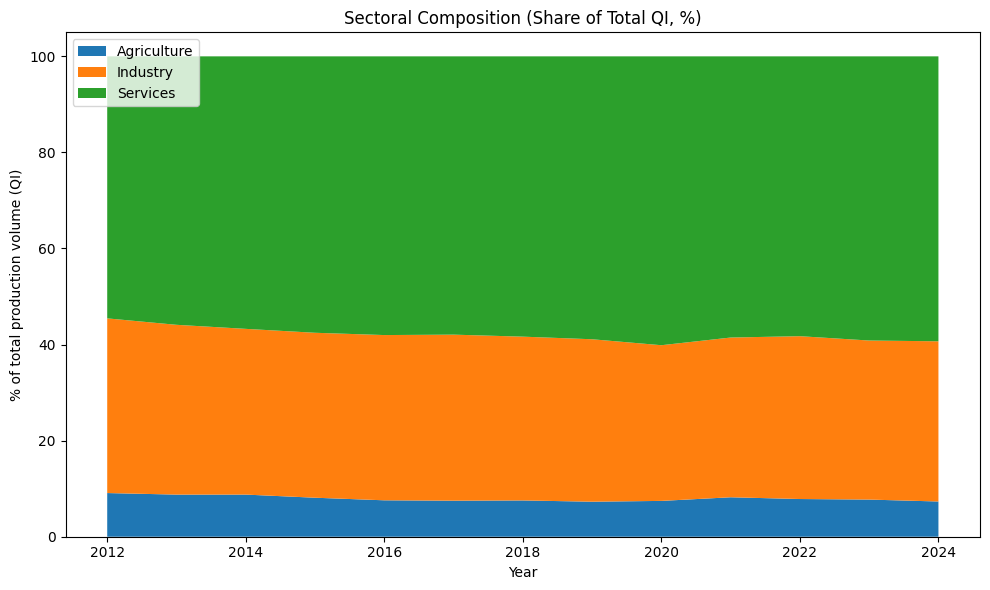

Saved: outputs_page2\page2_sectoral_composition_qi.png


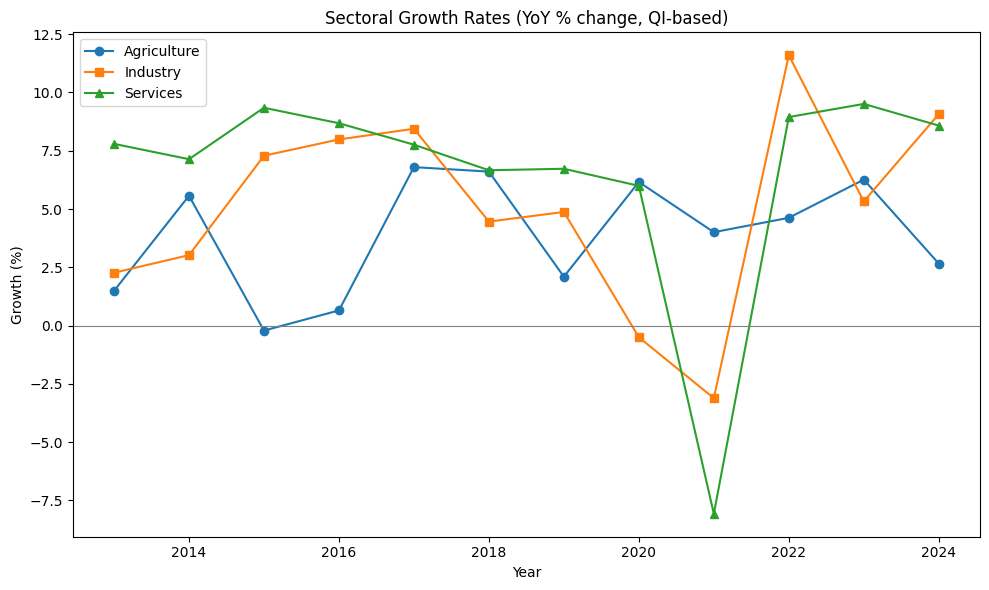

15:58:19 - cmdstanpy - INFO - Chain [1] start processing


Saved: outputs_page2\page2_sectoral_growth_qi.png


15:58:19 - cmdstanpy - INFO - Chain [1] done processing


Saved: outputs_page2\gdp_forecast_page2.csv


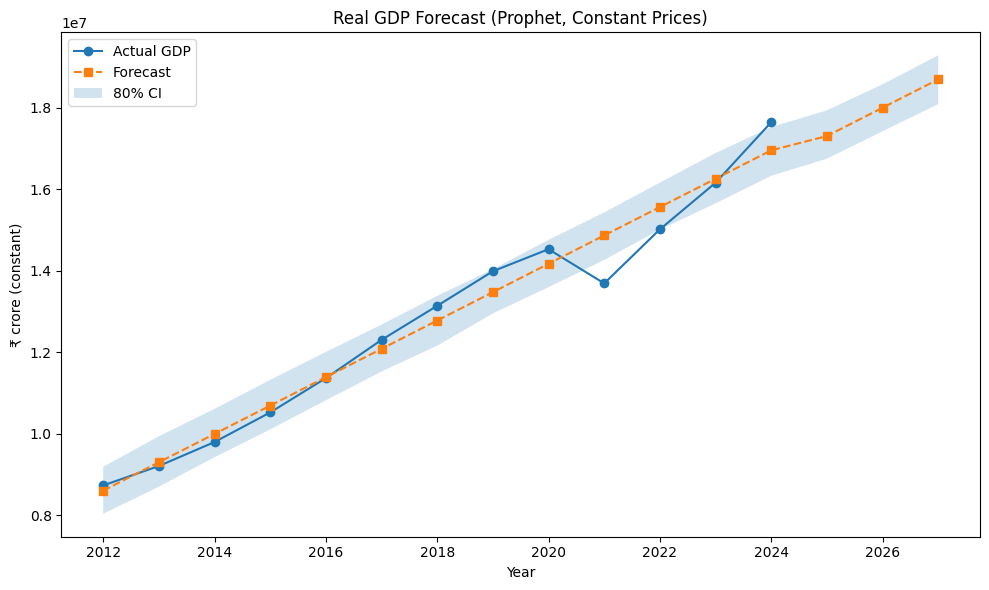

Saved: outputs_page2\page2_gdp_forecast.png
Evaluation on 13 overlapping years: MAE = 351,707.22, RMSE = 466,817.23, Avg rel error = 2.59%
 Year  GDP_Constant         yhat
 2012  8.736329e+06 8.609009e+06
 2013  9.213017e+06 9.304520e+06
 2014  9.801370e+06 1.000003e+07
 2015  1.052767e+07 1.069554e+07
 2016  1.136949e+07 1.139296e+07
 2017  1.230819e+07 1.208847e+07
 2018  1.314458e+07 1.278398e+07
 2019  1.399291e+07 1.347949e+07
 2020  1.453464e+07 1.417691e+07
 2021  1.369487e+07 1.487242e+07
 2022  1.502185e+07 1.556794e+07
 2023  1.616491e+07 1.626345e+07
 2024  1.765059e+07 1.696086e+07
All outputs saved in: D:\work-freelance-code\work\MacroEconomicsAnalysis-Modelling\notebooks\page2\outputs_page2


In [22]:
# ===== page2_production_fixed_block.py =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ensure out_dir exists (use the folder you mentioned earlier)
try:
    out_dir
except NameError:
    out_dir = Path("./outputs_page2")
out_dir = Path(out_dir)
if not out_dir.exists():
    raise SystemExit(f"Output folder {out_dir} does not exist. Create it or set out_dir to the correct path (no new folders will be created).")

# assume p5 and p12 already loaded
# p5: constant GDP; p12: price & quantum indices
# ensure Year numeric
p5['Year'] = pd.to_numeric(p5['Year'], errors='coerce').astype('Int64')
p12['Year'] = pd.to_numeric(p12['Year'], errors='coerce').astype('Int64')

# ========== BUILD QI AGGREGATES ==========
qi = p12.copy()

def get(colname):
    # return numeric series (NaNs if missing); caller will handle NaNs
    return pd.to_numeric(qi[colname], errors='coerce') if colname in qi.columns else pd.Series([np.nan]*len(qi), index=qi.index)

# Map exact p12 column names (adjust these if your p12 uses slightly different strings)
qi["QI_Agriculture"] = get("QI - agriculture, forestry & fishing")
qi["QI_Industry"] = ( get("QI - mining & quarrying")
                    + get("QI - manufacturing")
                    + get("QI - electricity, gas, water supply & other utility services")
                    + get("QI - construction") )
qi["QI_Services"] = ( get("QI - trade, repair, hotels & restaurants")
                   + get("QI - transport, storage, communication & services related to broadcasting")
                   + get("QI - financial services")
                   + get("QI - real estate, ownership of dwelling & professional services")
                   + get("QI - public administration and defence")
                   + get("QI - other services") )

# Keep Year rows even if some sector QI are NaN; compute Total_QI with numeric coercion
agg = qi[['Year','QI_Agriculture','QI_Industry','QI_Services']].copy()
# If a row has all NaNs for the three QIs, drop it; otherwise keep and compute totals
agg = agg[~(agg[['QI_Agriculture','QI_Industry','QI_Services']].isna().all(axis=1))].copy()
agg = agg.sort_values('Year').reset_index(drop=True)

# compute total as sum (NaNs treated as 0 for the sum)
agg['Total_QI'] = agg[['QI_Agriculture','QI_Industry','QI_Services']].fillna(0).sum(axis=1)

# Avoid division by zero: where Total_QI == 0 -> set shares to NaN
agg['Agri_Share_%'] = np.where(agg['Total_QI']>0, (agg['QI_Agriculture'].fillna(0) / agg['Total_QI']) * 100, np.nan)
agg['Ind_Share_%']  = np.where(agg['Total_QI']>0, (agg['QI_Industry'].fillna(0)  / agg['Total_QI']) * 100, np.nan)
agg['Serv_Share_%'] = np.where(agg['Total_QI']>0, (agg['QI_Services'].fillna(0)  / agg['Total_QI']) * 100, np.nan)

# growth rates (YoY %) using pct_change on the level QI series
agg['Agri_Growth_%'] = agg['QI_Agriculture'].pct_change() * 100
agg['Ind_Growth_%']  = agg['QI_Industry'].pct_change() * 100
agg['Serv_Growth_%'] = agg['QI_Services'].pct_change() * 100

# Save QI summary CSV
qi_summary_fp = out_dir / "production_qi_summary.csv"
agg.to_csv(qi_summary_fp, index=False)
print("Saved:", qi_summary_fp)

# ========== CHART 1: SECTORAL COMPOSITION (stacked area of shares) ==========
fig, ax = plt.subplots(figsize=(10,6))
# use Year as x and shares as stacked areas; fill NaNs with 0 for plotting only
ax.stackplot(agg['Year'],
             agg['Agri_Share_%'].fillna(0),
             agg['Ind_Share_%'].fillna(0),
             agg['Serv_Share_%'].fillna(0),
             labels=['Agriculture','Industry','Services'])
ax.set_title("Sectoral Composition (Share of Total QI, %)")
ax.set_xlabel("Year")
ax.set_ylabel("% of total production volume (QI)")
ax.legend(loc="upper left")
fig.tight_layout()
comp_fp = out_dir / "page2_sectoral_composition_qi.png"
fig.savefig(comp_fp, dpi=200)
plt.show()
print("Saved:", comp_fp)

# ========== CHART 2: SECTORAL GROWTH RATES (YoY%) ==========
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(agg['Year'], agg['Agri_Growth_%'], marker='o', label='Agriculture')
ax.plot(agg['Year'], agg['Ind_Growth_%'], marker='s', label='Industry')
ax.plot(agg['Year'], agg['Serv_Growth_%'], marker='^', label='Services')
ax.set_title("Sectoral Growth Rates (YoY % change, QI-based)")
ax.set_xlabel("Year")
ax.set_ylabel("Growth (%)")
ax.axhline(0, color='gray', lw=0.8)
ax.legend()
fig.tight_layout()
growth_fp = out_dir / "page2_sectoral_growth_qi.png"
fig.savefig(growth_fp, dpi=200)
plt.show()
print("Saved:", growth_fp)

# ========== MODEL: PROPHET FORECAST ON REAL GDP ==========
# prepare GDP series; ensure numeric and sorted by Year
gdp = p5[['Year','GDP']].rename(columns={'GDP':'GDP_Constant'}).dropna(subset=['Year']).copy()
gdp['GDP_Constant'] = pd.to_numeric(gdp['GDP_Constant'], errors='coerce')
gdp = gdp.sort_values('Year').reset_index(drop=True)

# build prophet dataframe (ds must be datetime)
df_prophet = pd.DataFrame({
    'ds': pd.to_datetime(gdp['Year'].astype(int).astype(str) + "-07-01"),
    'y': gdp['GDP_Constant'].astype(float)
})

model = Prophet(yearly_seasonality=False)
model.fit(df_prophet)

# forecast 3 years ahead (freq 'YS' to generate yearly timestamps)
future = model.make_future_dataframe(periods=3, freq='YS')
forecast = model.predict(future)

# prepare forecast frame and merge with actuals by Year
fc = forecast[['ds','yhat','yhat_lower','yhat_upper']].copy()
fc['Year'] = fc['ds'].dt.year
merged = pd.merge(gdp, fc, on='Year', how='right').sort_values('Year').reset_index(drop=True)

# Save forecast CSV
fc_fp = out_dir / "gdp_forecast_page2.csv"
merged.to_csv(fc_fp, index=False)
print("Saved:", fc_fp)

# Forecast plot
fig, ax = plt.subplots(figsize=(10,6))
# plot actuals where available
mask_actual = merged['GDP_Constant'].notna()
if mask_actual.any():
    ax.plot(merged.loc[mask_actual,'Year'], merged.loc[mask_actual,'GDP_Constant'], label='Actual GDP', marker='o')
# plot forecast median
ax.plot(merged['Year'], merged['yhat'], label='Forecast', linestyle='--', marker='s')
# plot CI if available
if 'yhat_lower' in merged.columns and 'yhat_upper' in merged.columns:
    ax.fill_between(merged['Year'], merged['yhat_lower'], merged['yhat_upper'], alpha=0.2, label='80% CI')
ax.set_title("Real GDP Forecast (Prophet, Constant Prices)")
ax.set_xlabel("Year")
ax.set_ylabel("₹ crore (constant)")
ax.legend()
fig.tight_layout()
fc_plot_fp = out_dir / "page2_gdp_forecast.png"
fig.savefig(fc_plot_fp, dpi=200)
plt.show()
print("Saved:", fc_plot_fp)

# ========== SAFE EVALUATION: align by Year and compute metrics only if overlap exists ==========
# keep only rows where both actual and forecast exist
eval_df = merged[['Year','GDP_Constant','yhat']].copy()
eval_df['GDP_Constant'] = pd.to_numeric(eval_df['GDP_Constant'], errors='coerce')
eval_df['yhat'] = pd.to_numeric(eval_df['yhat'], errors='coerce')
eval_df = eval_df.dropna(subset=['GDP_Constant','yhat']).reset_index(drop=True)

if eval_df.empty:
    print("No overlapping actual+forecast years available for evaluation. Skipping MAE/RMSE calculation.")
else:
    y_true = eval_df['GDP_Constant'].astype(float).values
    y_pred = eval_df['yhat'].astype(float).values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rel_errors = np.abs(y_true - y_pred) / np.where(y_true==0, np.nan, y_true)
    avg_rel_error_pct = np.nanmean(rel_errors) * 100
    print(f"Evaluation on {len(eval_df)} overlapping years: MAE = {mae:,.2f}, RMSE = {rmse:,.2f}, Avg rel error = {avg_rel_error_pct:.2f}%")
    print(eval_df.to_string(index=False))

print("All outputs saved in:", out_dir.resolve())
# ============================================


In [23]:
# ========== SAVE CSV for Chart 1 (sectoral composition) ==========
comp_csv_fp = out_dir / "page2_sectoral_composition_qi.csv"
agg[['Year', 'Agri_Share_%', 'Ind_Share_%', 'Serv_Share_%']].to_csv(comp_csv_fp, index=False)
print("Saved:", comp_csv_fp)


Saved: outputs_page2\page2_sectoral_composition_qi.csv
